<a href="https://colab.research.google.com/github/gurubhargav999/Azure/blob/gbr/Hazard_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd

# Load the Excel file
file_path = '/content/drive/MyDrive/vw_DS_FamilyDetails-2.xlsx'
data = pd.read_excel(file_path)

# Display the first few rows and columns of the dataset to understand its structure
data.head(), data.columns


(  FamilyId            LastLogon IsActive  AgencyId AgencyName UserTyoe  \
 0     9580  2023-03-28 01:24:12    False         0        NaN      NaN   
 1     9584  2022-11-20 06:19:10     True         0        NaN      NaN   
 2     9585  2022-11-20 17:21:03    False         0        NaN      NaN   
 3     9592  2022-11-21 03:06:30    False         0        NaN      NaN   
 4     9593  2022-11-21 15:52:57     True         0        NaN      NaN   
 
   agentId parent_experience criminalHistory              License  ...  \
 0     NaN               NaN             NaN  Foster license only  ...   
 1     NaN               NaN             NaN                  NaN  ...   
 2     NaN               NaN             NaN                  NaN  ...   
 3     NaN               NaN             NaN                  NaN  ...   
 4     NaN               NaN             NaN                  NaN  ...   
 
   Duration Date OffRamp to Recruited Duration Date Recruited to Approved  \
 0                       

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11507 entries, 0 to 11506
Columns: 114 entries, FamilyId to eligibleText
dtypes: datetime64[ns](3), float64(10), int64(1), object(100)
memory usage: 10.0+ MB


In [4]:
pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 7.2 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=e8735ec1dcb8eb04e24c9995c45747f709b70616148650af9bbfe049f38bf0d9
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


In [12]:
# Apply the transformation
data['criminalHistory'] = data['criminalHistory'].apply(lambda x: 'No' if x == 'Clear' else 'Yes')

# Verify the changes
print(data['criminalHistory'].value_counts())


criminalHistory
No     6623
Yes    4884
Name: count, dtype: int64


In [13]:
# Select relevant columns for one-hot encoding and Cox analysis
columns_to_encode = ['IsActive', 'familyGoals_Race', 'familyGoals_HispanicOrLatino',
                     'eligibleText', 'TrainingComplete', 'criminalHistory', 'assessmentsComplete']

# Perform one-hot encoding on the selected columns
data_encoded = pd.get_dummies(data, columns=columns_to_encode, drop_first=True)

# Check for any relevant duration column for survival analysis
# We'll use 'Duration Bin Created to OffRamp' for Cox analysis, converting to numeric bins if necessary
# We'll convert it to a numeric form (e.g., by mapping each bin to a midpoint value in days)

# Mapping the duration bins to numeric values (midpoints in days)
duration_mapping = {
    '0-10 days': 5, '11-20 days': 15, '21-30 days': 25, '31-40 days': 35,
    '41-50 days': 45, '51-60 days': 55, '61-70 days': 65, '71-80 days': 75,
    '81-90 days': 85, '91-100 days': 95, '101-110 days': 105, '111-120 days': 115,
    '121-130 days': 125, '131-140 days': 135, '141-150 days': 145, '151-160 days': 155,
    '161-170 days': 165, '171-180 days': 175, '181-190 days': 185, '191-200 days': 195
}

# Apply the mapping to convert the 'Duration Bin Created to OffRamp' to numeric form
data_encoded['duration'] = data_encoded['Duration Bin Created to OffRamp'].map(duration_mapping)

# Remove rows with missing duration values
data_clean = data_encoded.dropna(subset=['duration'])

# Create a binary event variable from 'eligibleId' where 1 = process completed, 0 = still in progress
data_clean['event'] = (data_clean['eligibleId'] == 1.0).astype(int)


# Display the prepared data
data_clean[['duration', 'event']].head()

<ipython-input-13-b39219acea01>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['event'] = (data_clean['eligibleId'] == 1.0).astype(int)


,duration,event
0,5.0,0
1,5.0,1
2,5.0,0
3,5.0,1
4,5.0,1


In [14]:
from lifelines import CoxPHFitter



# Include the new criminal history and assessment completed columns in the Cox model
cox_data = data_clean[['duration', 'event', 'IsActive_True', 'familyGoals_Race_No Preference',
                       'familyGoals_HispanicOrLatino_Yes', 'TrainingComplete_No',
                       'criminalHistory_Yes', 'assessmentsComplete_Yes']]

# Fit the Cox proportional hazards model
cph = CoxPHFitter()
cph.fit(cox_data, duration_col='duration', event_col='event')

# Display the summary of the Cox model
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 11333 total observations, 3910 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 11333
number of events observed = 7423
   partial log-likelihood = -65255.70
         time fit was run = 2024-09-07 20:59:21 UTC

---
                                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                
IsActive_True                      0.38       1.47       0.03             0.33             0.43                 1.39                 1.54
familyGoals_Race_No Preference     0.00       1.00       0.03            -0.05             0.06                 0.95                 1.06
familyGoals_HispanicOrLatino_Yes  -0.01       0.99       0.04            -0.09             0.07                 0.91                 1.07
TrainingComplete_No               -0.06       0.94       0.05            -0.16             0.04                 0.85                 1.04
criminalHistory_Yes                0.57       1.77       0.03             0.52             0.62                 1.68                 1.86
assessmentsComplete_Yes           -0.14       0.87       0.03            -0.20            -0.09                 0.82                 0.91

                                   cmp to     z      p   -log2(p)
covariate                                                        
IsActive_True                        0.00 15.03 <0.005     167.18
familyGoals_Race_No Preference       0.00  0.07   0.94       0.09
familyGoals_HispanicOrLatino_Yes     0.00 -0.31   0.76       0.40
TrainingComplete_No                  0.00 -1.15   0.25       2.01
criminalHistory_Yes                  0.00 21.95 <0.005     352.26
assessmentsComplete_Yes              0.00 -5.25 <0.005      22.64
---
Concordance = 0.70
Partial AIC = 130523.40
log-likelihood ratio test = 992.93 on 6 df
-log2(p) of ll-ratio test = 699.33

<Axes: xlabel='HR (95% CI)'>

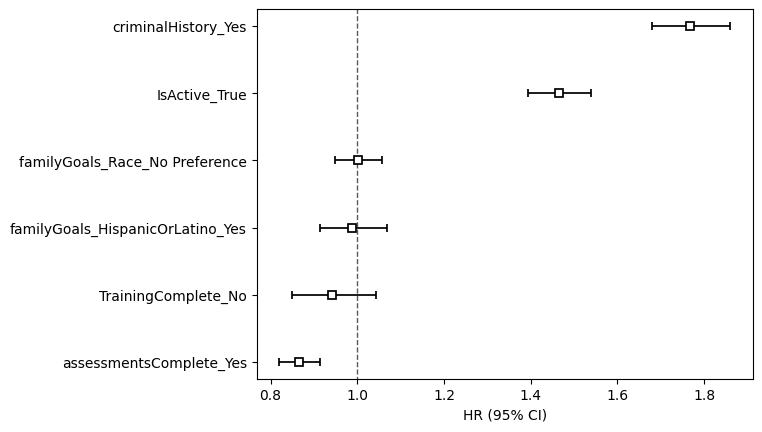

In [15]:
cph.plot(hazard_ratios=True)